# Sound Analyzer
### Tools and methods to analyze sound signals and to generate visualizations.
### Sumudu Tennakoon
### Last Update: 2019-01-14

In [1]:
import numpy as np
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyaudio
import time
import wave

## Detect Sound From PC Mic

In [2]:
def capture_sound(frames_per_buffer=1024,
                  pa_format='paInt16',
                  channels=1,
                  input_device_index=0,
                  record_time = 10.0,
                  sample_rate = 44100,
                  save_file = None,
                  init_wait =1.0,
                  time_label = 't',
                  ampl_label = 's',
                  capture_label = 'signal',
                  return_type='frame',
                  save_file_path = None,
                  show_plot=False):
    """
    Parameters
    ----------
    frames_per_buffer : int, default 1024
    pa_format : {'paInt8', 'paInt16', 'paInt32'}, default 'Int16' 
        https://people.csail.mit.edu/hubert/pyaudio/docs/#details
    channels : int, default 1
    input_device_index : int, default 0
    record_time : float, default 10 (in seconds)
    sample_rate : int, default 44100
    save_file : int, default None
    init_wait : float, default 1.0
    time_label : str, default t'
    ampl_label : str, default 's'   
    capture_label : str, default 'signal'
    return_type : {'frame', 'dict', None}, default 'frame'
    save_file_path : str, default None
        file path if need to save recording to wave file
    show_plot : bool, default False
    
    Returns
    -------
    Signal : pd.DataFrame or dict or (np.array, np.array)
        selection based on the value provided to return_type
    """
    
    audio_format_dict = {
        'paInt8' : [pyaudio.paInt8, 'Int8'],
        'paInt16' : [pyaudio.paInt16, 'Int16'],
        'paInt32' : [pyaudio.paInt32, 'Int32']
    } 
    
    audio_format = audio_format_dict[pa_format][0]
    data_type = audio_format_dict[pa_format][1]
    
    pa = pyaudio.PyAudio()

    stream = pa.open(format=audio_format,
                channels=channels,
                rate=sample_rate,
                input=True,
                frames_per_buffer=frames_per_buffer,
                input_device_index=input_device_index)

    time.sleep(init_wait)

    print("started recording", record_time, "seconds")
    frames = []
    for i in range(0, sample_rate//frames_per_buffer * int(record_time)+1):
        frame = stream.read(frames_per_buffer)
        frames.append(frame)
    print("done recording.")
    
    stream.stop_stream()
    stream.close()
    pa.terminate()

    print("strat decoding.")
    signal = []
    
    if save_file_path != None:
        wf = wave.open(save_file_path, 'wb')
        wf.setnchannels(channels)
        wf.setsampwidth(pa.get_sample_size(audio_format))
        wf.setframerate(sample_rate)
        wf.writeframes(b''.join(frames))
        wf.close()

    for frame in frames:
        signal_chunk=np.fromstring(frame, data_type)  
        signal = signal + signal_chunk.tolist()

    signal = np.array(signal)
    N = len(signal)
    t_max = N/sample_rate
    t =np.linspace(0, t_max, N)
    print("done decoding.")
    
    if show_plot:
        plt.plot(t, signal, label=capture_label)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude [.]')
        plt.legend()
        plt.show()
        
    if return_type == 'frame':
        Signal = pd.DataFrame(data={time_label:t, ampl_label:signal})
        return Signal
    elif return_type == 'dict':
        return {time_label:t, ampl_label:signal}
    else:
        return t, signal

In [3]:
def compute_spectogram(signal,
               t = None,
               signal_label='s',  
               time_label='t', 
               window='hann', 
               nfft=1024, 
               noverlap=20, 
               sample_rate=44100, 
               min_freq=None,
               max_freq=None,             
               scaling='density', 
               scale='default', 
               scale_by_freq=True, 
               pad_to=None,
               mode='psd',
               backend='mpl',
               cmap=None,
               retrun_fig=False):
    """
    Parameters
    ----------
    signal : np.array
    t : np.array
    signal_label : str, default 's'
    time_label : str, default 't'
    window : {'boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett', 'flattop', 'parzen', 'bohman', ...}
        Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window
        backend='mpl' supports {'blackman', 'hamming', 'hann', 'bartlett'} windows only 
    nfft : int, default 256
    noverlap : int, default 20
    sample_rate : int, default 44100
    min_freq : float, default None
    max_freq : float, default None
    scaling : {'density', 'spectrum'}
    scale : {'default', 'linear', 'dB'}, default 'default'
        only for matplotlib backend
    scale_by_freq  : bool, default True
        only for matplotlib backend
        Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.specgram.html
    pad_to : int, default None
        only for matplotlib backend
    mode : {'psd', 'complex', 'magnitude', 'angle', 'phase'} 
    backend : {'mpl', 'scipy'}, default 'mpl'
        Ref 'mpl' : https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.specgram.html
        Ref 'scipy' : https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    cmap : matplotlib.colors.Colormap, default None
        Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.colors.Colormap.html#matplotlib.colors.Colormap
    retrun_fig : bool, default False    
    
    Returns
    -------
    t : np.array
    f : np.array
    spectrum : np.array
        2D Array
    fig : matplotlib.image.AxesImage (optional, only if retrun_fig=True)
        https://matplotlib.org/3.1.1/api/image_api.html#matplotlib.image.AxesImage
    """

    def sclae_spectrum(spectrum, mode, scale):
        if scale=='dB':
            if mode=='psd':
                return 10*np.log10(spectrum)
            elif mode=='magnitude':
                return 20*np.log10(spectrum)
            else:
                return spectrum
        else:
            return spectrum
        
    if type(signal) == type(Signal)==pd.core.frame.DataFrame:
        t = signal[time_label].values
        signal = signal[signal_label].values
    
    try:
        if t==None:
            N = len(signal)
            t_max = N/sample_rate
            t =np.linspace(0, t_max, N)
    except:
        pass
    
    if min_freq == None:
        min_freq = 0
    if max_freq == None:
        max_freq = sample_rate/2
        
    window_dict = {
        'hann' : lambda x: np.hanning(len(x))*x,
        'hamming' : lambda x: np.hamming(len(x))*x,
        'blackman' : lambda x: np.blackman(len(x))*x,
        'bartlett' : lambda x: np.bartlett(len(x))*x
    }
    
    fig, axes = plt.subplots(nrows=2, sharex=True)
    axes[0].set_xlabel('Time [s]')
    axes[0].set_ylabel('Amplitude [.]')
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('Frequency [Hz]')  
    
    axes[0].plot(t, signal)
    if backend=='mpl':
        try:
            window=window_dict[window]
        except:
            print("Window '{}' is not supported. Setting window to 'hann'".format(window))
            window=window_dict['hann']
            
        spectrum, f, t, image = axes[1].specgram(signal, 
                                                 NFFT=nfft, 
                                                 Fs=sample_rate, 
                                                 window=window, 
                                                 mode=mode, 
                                                 scale=scale,
                                                 scale_by_freq=scale_by_freq,
                                                 noverlap=noverlap,
                                                 cmap='jet')
        spectrum = sclae_spectrum(spectrum, mode, scale)
    elif backend=='scipy':
        f, t, spectrum  = scipy.signal.spectrogram(signal, 
                                                nfft=nfft, 
                                                fs=sample_rate, 
                                                window=window, 
                                                noverlap=noverlap, 
                                                scaling=scaling, 
                                                mode=mode)
        spectrum = sclae_spectrum(spectrum, mode, scale)
        image = axes[1].pcolormesh(t, f, spectrum, cmap='jet')
        
    else:
        print('Unsupported backend')
    
    axes[1].set_ylim(min_freq, max_freq)
    
    fig.colorbar(image, ax=axes[1], orientation='horizontal', pad=0.3)
    fig.tight_layout()
    
    if retrun_fig:
        return t, f, spectrum, fig
    else:
        return t, f, spectrum

In [4]:
def plot_spectogram(t, f, spectrum, min_freq=None, max_freq=None, signal=None, sample_rate=None, s_t=None):
    fig, axes = plt.subplots(nrows=2, sharex=True)
    axes[0].set_xlabel('Time [s]')
    axes[0].set_ylabel('Amplitude [.]')
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('Frequency [Hz]')   
    
    im_sg = axes[0].plot(t, signal)
    im_sp = axes[1].pcolormesh(t, f, spectrum, cmap='jet')
    
    axes[1].set_ylim(min_freq, max_freq)
    
    fig.colorbar(im_sp, ax=axes[1], orientation='horizontal', pad=0.3)
    fig.tight_layout()

started recording 16.0 seconds
done recording.
strat decoding.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


done decoding.


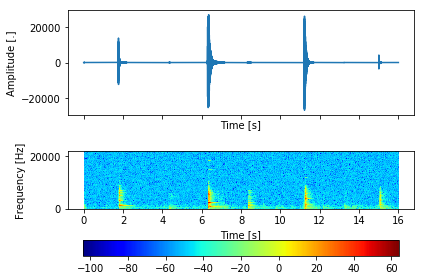

In [5]:
Signal = capture_sound(frames_per_buffer=1024,
                          pa_format='paInt16',
                          channels=1,
                          input_device_index=0,
                          record_time = 16.0,
                          sample_rate = 44100,
                          save_file = None,
                          init_wait =1.0,
                          time_label = 't',
                          ampl_label = 's',
                          capture_label = 'signal',
                          return_type='frame',
                          save_file_path = r'C:\Projects\G\test.wav',
                          show_plot=False)

t, f, spectrum = compute_spectogram(Signal)

In [6]:
%matplotlib auto

signal = Signal['s'].values
t, f, spectrum, fig = compute_spectogram(signal, nfft=1024, min_freq=0, max_freq=10000, noverlap=2, backend='mpl', scale='dB', retrun_fig=True)
plt.show()

Using matplotlib backend: Qt5Agg


In [7]:
%matplotlib auto

signal = Signal['s'].values
t, f, spectrum, fig = compute_spectogram(signal, nfft=1024, min_freq=0, max_freq=10000, noverlap=2, backend='scipy', scale='dB', retrun_fig=True, scaling ='density')

Using matplotlib backend: Qt5Agg
